<a href="https://colab.research.google.com/github/NikosKats/ColabFiles/blob/TrainingAClassifier_CIFAR-10/TrainingAClassifier_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch #imports the PyTorch library
import torchvision #this package contains datasets and model architectures for image classification
import torchvision.transforms as transforms #is used to perform data preprocessing
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Compose is used to composed multiple transformations together
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip the images horizontally with probability of 0.5
    transforms.RandomCrop(32, padding=4), # randomly crop image of size 32x32 from original with 4 pixels of padding
    transforms.ToTensor(), # Convert PIL image to torch.Tensor, from HWC[0,255] to CHW[0,1]
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # normalize the data by applying the standard deviation, this converts the image from a range of [0,1] to [-1,1]

])

In [3]:
# change batch size in order to load different size of images each time
batch_size = 8

In [20]:
#Loads the training set of the CIFAR-10 dataset. THe `root` argument specifies the location where the data will be downloaded and stored. If the data is not
# already present there, it will be downloaded. The `train` argument specifies whether to load the training set or the test set. By setting it to `True`,
# we're loading the training set. The `download` argument, when set to `True`, downloads the data if it isn't present in the `root` directory.
# Finally, the `Transform` argument specifies the preprocessing that should be applied to data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [21]:
# `torch.utils.data.DataLoader`: this class provides an iterator over the dataset, which is used to load the data in small batches
# `trainset`: the dataset object that we want to load the data from
# `batch_size=batch_size`: The number of samples in each batch. The DataLoader will load the data in chunks of this size.
# Larger batch sizes generally lead to faster training , but they also require more memory.
# `shuffle=True`: This shuffles the data before each epoch. This is important because, if the data is not shuffled, the model might not see all classes in a single pass.
# `num_workers=2`: Number of worker threads for loading the data. This argument is passed on the `torch.utils.data.DataLoader` constructor.
# This argument will cause data loading to be parallelized across multiple threads. This can be useful for loading large datasets, since it can significantly speed up the loading
# time. However, it can also increase the memory footprint of your program.

# in summary this code is loading the training dataset in batches of batch size with shuffling enabled and using 2 worker threads to speed up loading data.
# It returns an iterator over the dataset that is stored in the variable `trainloader`, so that we can iterate over the training set and load the data in chunks of size batch_size.


In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [7]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [22]:
# it creates a tupled named classes representing the different classes that are listed in CIFAR-10 dataset
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

In [23]:
# the imshow function is used to display an image, it takes an `img` as input and perform the following operations:
# `img = img / 2 + 0.5` : This line of code is used to unormalize the image. In the previous steps, the images have
#  been normalized by subtracting the mean and dividing by the standard deviation of each color channel and converting
#  to a tensor. This line of code reverses this process by multiplying the values of the tensor by 2 and adding 0.5 back.
# `npimg = img.numpy()`: This line of code converts the image from PyTorch tensor to a numpy array.
# `plt.imshow(np.transpose(npimg, (1, 2, 0)))`: This line of code is used to display the image using matplotlib's `imshow` function.
# The `np.transpose` function is used to transpose the axes of the numpy array, so that the image is displayed in the correct format (HxWxC).
# Without transpose, the image will be displayed with transposed axes, which will show an incorrect image format.
# `plt.show()`: This line of code is used to display the image.

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

In [24]:
# `dataiter = iter(trainloader)`: Creates an iterator object that can be used to access elements in the `trainloader` object.
# The `iter()` function is a built-in Python function that returns an iterator for an iterable object such as a list, tuple, or a PyTorch DataLoader object.
dataiter = iter(trainloader)

In [25]:
# `images, labels = next(dataiter)`: THis line of code retrieves the next item from the iterator object. The `next()` function is a built-in Python function
# that retrieves the next iter as iterator. The `next(dataiter) expression returns a tuple containing the next batch of images and labels from the `trainloader` object
# The variables images and labels are then assigned the respective items of the tuple.
# In this specific casw, `trainloader` is loading images in batches, so `next(dataiter)` will retrieve the next batch of images and labels, each time the code is executed,
# so you will have to call the `next()` function multiple times if you want to iterate through all the images in the dataset.


images,labels = next(dataiter)

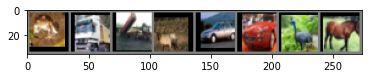

In [26]:

# The `imshow` function is used to display a single image, in this case it's used to display grid images that are created by `torchvision.utils.make_grid(images)`,
# so it will allow to see all images in the grid by changing only the inputs. The grid images are made of several images concatenated together so it will look like
# one image, but it's made of multiple images
imshow(torchvision.utils.make_grid(images))

In [13]:
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

frog  truck truck deer  car   car   bird  horse


In [14]:
# Define a Convolutional Neural Network
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
net = Net()

In [15]:
#Define a Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [27]:
# Train the network
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss +=loss.item()
    if i % 2000 == 1999:
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
      running_loss = 0.0

print('Finished Training')

RuntimeError: ignored

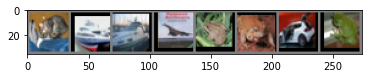

GroundTruth:  cat   ship  ship  plane
Predicted:  deer  deer  deer  deer 
Accuracy of the network on the 10000 test images: 10%


In [28]:
PATH = './cifar_net.path'
torch.save(net.state_dict,PATH)

dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

net = Net()

torch.save(net.state_dict(), PATH) # nothing else here
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


print(f'Accuracy of the network on the 10000 test images: {100 * correct // total}%')

In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
  for data in testloader: 
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    for label, prediction in zip(labels, predicted):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1



In [19]:
for classname, correct_count in correct_pred.items():
  accuracy = 100 * float(correct_count) / total_pred[classname]
  print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

net.to(device)

inputs,labels = data[0].to(device), data[1].to(device)

del dataiter

Accuracy for class: plane is 96.2 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.5 %
Accuracy for class: truck is 0.0 %
cuda:0
